In [ ]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

In [ ]:
# Examine Data
DATA_DIR = "DataSetFilePath"
train_df = pd.read_csv(os.path.join(DATA_DIR, "Train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "Test.csv"))
meta_df = pd.read_csv(os.path.join(DATA_DIR, "Meta.csv"))

print(train_df.head())
print("Number of classes:", train_df['ClassId'].nunique())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  
Number of classes: 43


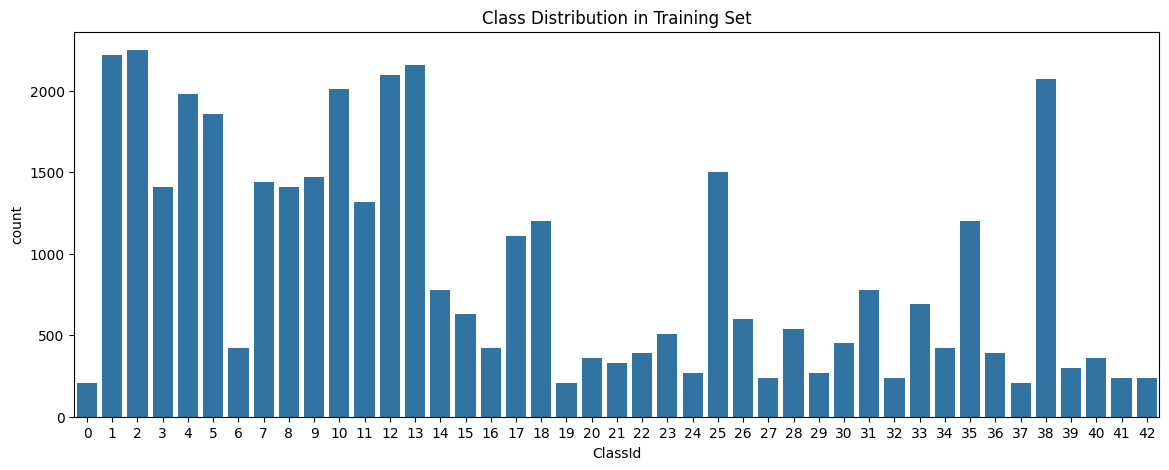

In [ ]:
# Exploratory Data Analysis (EDA)
# Class Distribution
plt.figure(figsize=(14,5))
sns.countplot(x='ClassId', data=train_df)
plt.title("Class Distribution in Training Set")
plt.show()

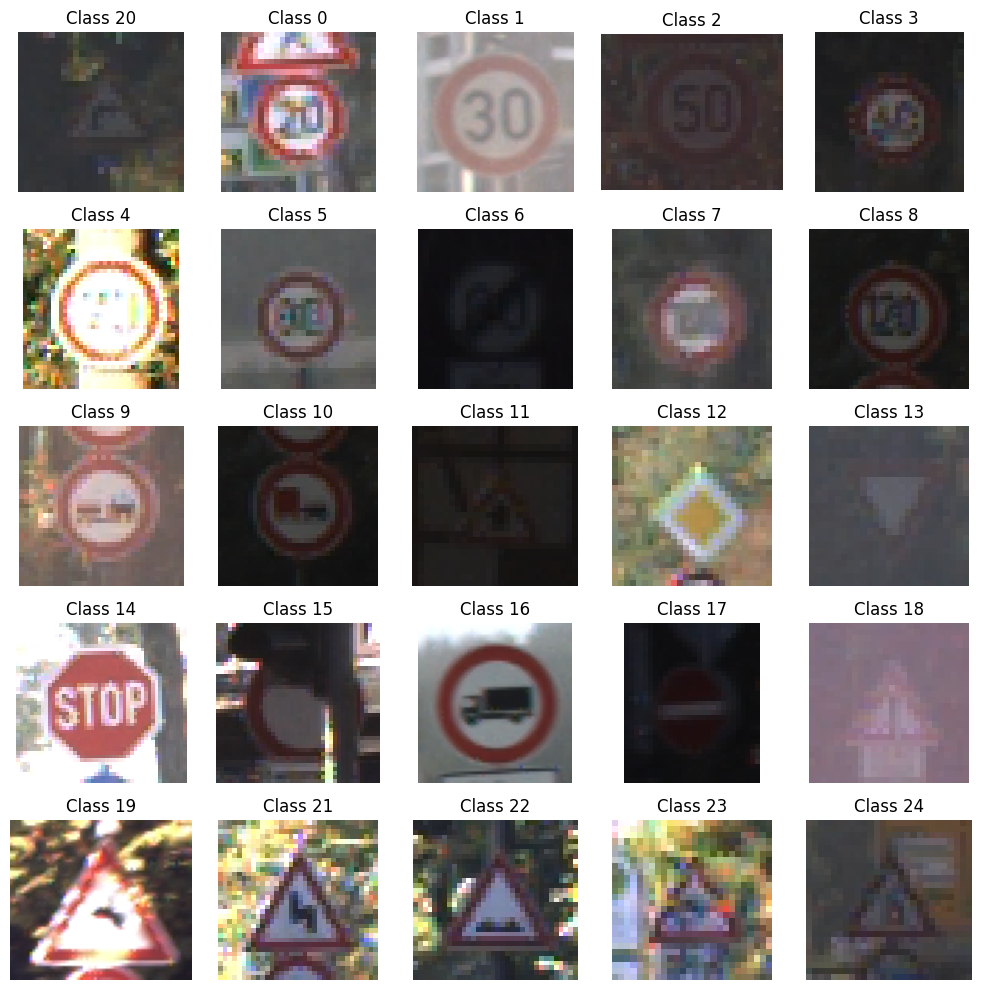

In [ ]:
# Sample Images Per Class
fig, axes = plt.subplots(5,5, figsize=(10,10))
axes = axes.flatten()

for i, class_id in enumerate(train_df['ClassId'].unique()[:25]):
    img_path = os.path.join(DATA_DIR, train_df[train_df['ClassId']==class_id].iloc[0]['Path'])
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Class {class_id}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**Five Potential Dataset Issues**
1. **Class Imbalance**  
   Some traffic signs have significantly more samples than others, implies biased learning.

2. **Varying Image Sizes**  
   Images have different resolutions, CNNs require fixed input shape.

3. **Lighting & Weather Variations**  
   Real-world conditions cause inconsistent brightness and contrast.

4. **Motion Blur & Occlusion**  
   Some signs are partially hidden or blurred.

5. **Visual Similarity Between Classes**  
   Speed-limit signs (30, 50, 60) are visually very similar; this might lead to harder classification.

In [ ]:
# Image Preprocessing (Resize & Normalize) - Took 240 seconds on a T4 GPU
IMG_SIZE = (32, 32)

def load_images(df):
    images = []
    labels = []

    for _, row in df.iterrows():
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(DATA_DIR, row['Path']),
            target_size=IMG_SIZE
        )
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0
        images.append(img)
        labels.append(row['ClassId'])

    return np.array(images), np.array(labels)

X, y = load_images(train_df)

In [ ]:
# Train / Validation / Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=77
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=77
)

print(X_train.shape, X_val.shape, X_test.shape)

(27446, 32, 32, 3) (5881, 32, 32, 3) (5882, 32, 32, 3)


In [ ]:
# Complie the Baseline CNN Model
baseline_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,363 (1.22 MB)

 Trainable params: 320,171 (1.22 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Train Baseline CNN - Took about 34 secs on T4 GPU
history_baseline = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5338 - loss: 1.8273 - val_accuracy: 0.5426 - val_loss: 1.6109
Epoch 2/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9246 - loss: 0.2424 - val_accuracy: 0.9694 - val_loss: 0.1045
Epoch 3/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9571 - loss: 0.1390 - val_accuracy: 0.9855 - val_loss: 0.0531
Epoch 4/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9718 - loss: 0.0909 - val_accuracy: 0.9748 - val_loss: 0.0764
Epoch 5/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9766 - loss: 0.0696 - val_accuracy: 0.9847 - val_loss: 0.0555
Epoch 6/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9756 - loss: 0.0741 - val_accuracy: 0.9837 - val_loss: 0.0530
Epoch 7/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9823 - loss: 0.0548 - val_accuracy: 0.9895 - val_loss: 0.0384
Epoch 8/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9825 - loss: 0.0532 - val_accuracy: 

In [ ]:
# Evaluate Baseline CNN Model
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(X_test, y_test)
print("Baseline Test Accuracy:", baseline_test_acc)


184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9887 - loss: 0.0412
Baseline Test Accuracy: 0.9887793064117432


In [ ]:
# Classification Report
y_pred = np.argmax(baseline_model.predict(X_test), axis=1)

print("Classification Report:", classification_report(y_test, y_pred))

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.96      1.00      0.98       333
           2       0.98      0.97      0.98       338
           3       0.99      0.99      0.99       212
           4       0.99      1.00      0.99       297
           5       0.98      0.96      0.97       279
           6       1.00      1.00      1.00        63
           7       1.00      0.97      0.99       216
           8       0.99      0.99      0.99       212
           9       1.00      0.99      0.99       221
          10       0.99      0.99      0.99       302
          11       0.98      0.99      0.98       198
          12       1.00      1.00      1.00       315
          13       0.99      1.00      1.00       324
          14       0.99      0.99      0.99       117
          15       1.00      1.00      1.00        95
          16     

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1
)

datagen.fit(X_train)

In [ ]:
# Retrain CNN with Augmentation
aug_model = tf.keras.models.clone_model(baseline_model)
aug_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_aug = aug_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=15
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


429/429 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.3138 - loss: 2.6757 - val_accuracy: 0.3607 - val_loss: 2.4440
Epoch 2/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.6672 - loss: 1.0334 - val_accuracy: 0.9111 - val_loss: 0.2898
Epoch 3/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.7782 - loss: 0.6733 - val_accuracy: 0.9390 - val_loss: 0.2041
Epoch 4/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.8378 - loss: 0.4940 - val_accuracy: 0.9600 - val_loss: 0.1160
Epoch 5/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8715 - loss: 0.4059 - val_accuracy: 0.9694 - val_loss: 0.0981
Epoch 6/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.8866 - loss: 0.3372 - val_accuracy: 0.9787 - val_loss: 0.0677
Epoch 7/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.9020 - loss: 0.2943 - val_accuracy: 0.9611 - val_loss: 0.1055
Epoch 8/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9143 - loss: 0.2704 - val_accurac

In [ ]:
# Evaluate Augmented CNN
aug_test_loss, aug_test_acc = aug_model.evaluate(X_test, y_test)
print("Augmented CNN Test Accuracy:", aug_test_acc)

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9870 - loss: 0.0358
Augmented CNN Test Accuracy: 0.9880992770195007


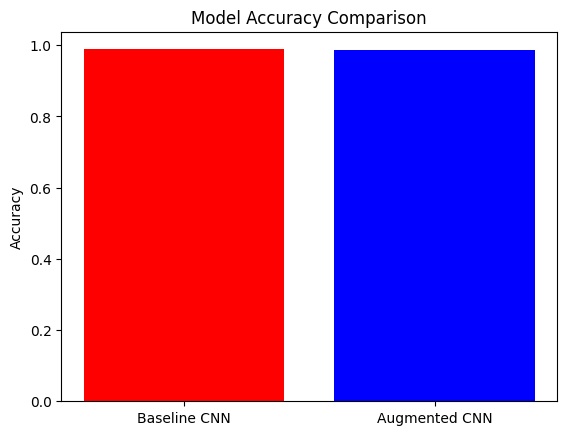

In [ ]:
# Performance Comparison (Baseline vs Augmented)
models = ['Baseline CNN', 'Augmented CNN']
accuracies = [baseline_test_acc, aug_test_acc]

plt.bar(models, accuracies)
plt.bar(models, accuracies, color=['red','blue'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Pre-trained MobileNetV2 Model
base_model = MobileNetV2(
    input_shape=(32,32,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

mobilenet_model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

mobilenet_model.compile(
    optimizer=Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/tmp/ipython-input-3813759381.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Train MobileNetV2
history_mobilenet = mobilenet_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=20
)

Epoch 1/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 60s 106ms/step - accuracy: 0.0541 - loss: 3.7218 - val_accuracy: 0.1280 - val_loss: 3.5262
Epoch 2/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.1248 - loss: 3.4730 - val_accuracy: 0.1648 - val_loss: 3.2785
Epoch 3/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.1502 - loss: 3.2636 - val_accuracy: 0.1836 - val_loss: 3.1191
Epoch 4/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.1660 - loss: 3.1234 - val_accuracy: 0.1984 - val_loss: 3.0153
Epoch 5/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.1755 - loss: 3.0473 - val_accuracy: 0.2091 - val_loss: 2.9421
Epoch 6/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.1866 - loss: 2.9644 - val_accuracy: 0.2173 - val_loss: 2.8849
Epoch 7/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.1991 - loss: 2.9219 - val_accuracy: 0.2238 - val_loss: 2.8395
Epoch 8/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.1997 - loss: 2.8827 -

184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.2499 - loss: 2.5915


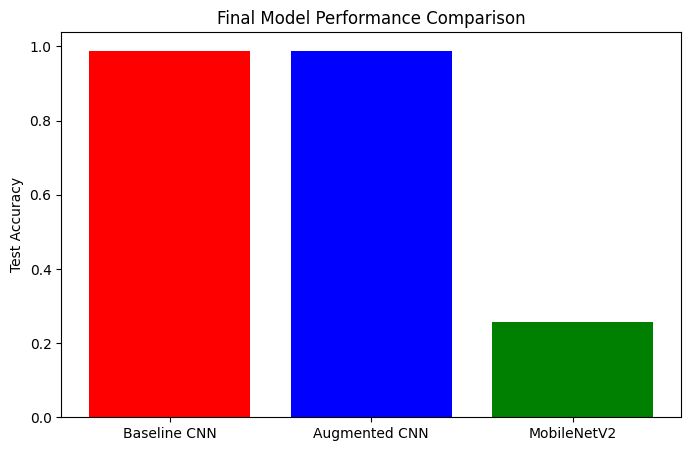

Baseline Test Accuracy: 0.9887793064117432
Augmented CNN Test Accuracy: 0.9880992770195007
MobileNetV2 Test Accuracy: 0.25671541690826416


In [ ]:
# Final Evaluation and Model Comparison ('Baseline CNN', 'Augmented CNN', 'MobileNetV2')
mobile_test_loss, mobile_test_acc = mobilenet_model.evaluate(X_test, y_test)

models = ['Baseline CNN', 'Augmented CNN', 'MobileNetV2']
accuracies = [baseline_test_acc, aug_test_acc, mobile_test_acc]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=['red','blue','green'])
plt.title("Final Model Performance Comparison")
plt.ylabel("Test Accuracy")
plt.show()

print("Baseline Test Accuracy:", baseline_test_acc)
print("Augmented CNN Test Accuracy:", aug_test_acc)
print("MobileNetV2 Test Accuracy:", mobile_test_acc)